<a id='importpackages'></a>
***
# Import Packages

### Standard Modules

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re

!pip install pprint
from pprint import pprint

from sklearn.model_selection import train_test_split
from collections import Counter

pd.set_option("display.max_columns", 50)
pd.set_option('display.max_colwidth', 200)
pd.options.display.max_rows = 1000
pd.options.mode.chained_assignment = None
df = pd.DataFrame

plt.style.use('default')
%matplotlib inline

### NLTK / NLP Modules

In [0]:
from string import ascii_letters, punctuation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics

!pip install nltk
from nltk.translate.bleu_score import sentence_bleu

!pip install rouge
from rouge import Rouge

!pip install unidecode
import unidecode

!pip install spacy
import spacy
nlp = spacy.load('en')

!pip install beautifulsoup4
from bs4 import BeautifulSoup

     |████████████████████████████████| 245kB 4.2MB/s 


### Neural Net Modules (Keras | Tensorflow | GPT-2)

In [0]:
import os

# !pip install tensorflow-gpu==2.0.0
import tensorflow as tf
os.environ['KERAS_BACKEND'] = 'tensorflow'

import logging
logging.getLogger('tensorflow').disabled = True

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.initializers import Constant

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, CuDNNLSTM, CuDNNGRU, LSTM, GRU, Embedding, Concatenate, TimeDistributed, Bidirectional, Dropout, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Model
from tensorflow.python.keras.optimizers import Adam

!pip install transformers
from transformers import GPT2LMHeadModel, GPT2Tokenizer

Using TensorFlow backend.


     |████████████████████████████████| 450kB 4.8MB/s 
     |████████████████████████████████| 1.0MB 40.6MB/s 
     |████████████████████████████████| 870kB 39.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884629 sha256=437137a1c5414ed011b12c0b2f44270c03c7e97206d4fbc2e080e554e14c440c
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


# Read Data & Prep
***

### Mount to Google Drive & Change Directory

In [0]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
os.chdir('/gdrive/My Drive/colab_notebooks/information_systems/data')

### Import Custom Attention Module(s)

In [0]:
import sys
sys.path.append('custom_modules')

from attention_01 import AttentionLayer
from attention_02 import Attention

## Remove Duplicate Rows

In [0]:
EPU = pd.read_csv('EPU_fullset.csv', encoding="ISO-8859-1")
EPU = EPU.drop('Unnamed: 0', axis=1)

In [0]:
EPU.drop_duplicates(subset=None, keep='first', inplace=True)
EPU.drop_duplicates(subset=['Article'], keep='first', inplace=True)

# Headline Cleaning
***

#### Build `papers` List & Remove Low-Count Papers

In [0]:
count_papers = EPU['Newspaper'].value_counts()
EPU = EPU[~EPU['Newspaper'].isin(count_papers[count_papers < 100].index)]

In [0]:
papers = list(EPU['Newspaper'].value_counts().index)
papers

['The Washington Post',
 'Pittsburgh Post-Gazette (Pennsylvania)',
 'The Atlanta Journal-Constitution',
 'St. Louis Post-Dispatch (Missouri)',
 'USA Today',
 'Star Tribune (Minneapolis, MN)',
 'The Philadelphia Inquirer (Pennsylvania)',
 'St. Petersburg Times (Florida)',
 'The Orange County Register (California)',
 'Tampa Bay Times',
 'The New York Post']

#### Remove Obituaries

In [0]:
interim = EPU.loc[EPU['Newspaper'] == 'Pittsburgh Post-Gazette (Pennsylvania)']
months_regex = '(?:JANUARY|FEBRUARY|MARCH|APRIL|MAY|JUNE|JULY|AUGUST|SEPTEMBER|OCTOBER|NOVEMBER|DECEMBER)'
interim['Obituary'] = interim['Headline'].apply(lambda header: 1 if re.match('.*\;\s' + months_regex + '\s\d+', header) else 0)
interim = interim.loc[interim['Obituary'] == 1]
obituary_indeces = interim.index
EPU = EPU[~EPU.index.isin(obituary_indeces)]

### Trim Short Headlines
***

##### Remove headlines with less than 4 words

In [0]:
EPU['Headline'] = EPU['Headline'].apply(lambda headline: '' if not len(str(headline).split()) >= 4 else headline)

### Define Headline Occurrence Counter Function

In [0]:
def build_headline_counter_dict():
  """Construct counter objects for commonly-occurring words / headlines."""

  papers = list(EPU[EPU.isin(count_papers.index[count_papers >= 100]).values]['Newspaper'].value_counts().index)
  paper_data_dict = {}
  for paper in papers:
    temp = EPU.loc[EPU['Newspaper'] == paper]
    temp_prefix_counter = Counter(temp['Headline'])
    temp_prefix_words = re.sub('\s\s+' , ' ', temp['Headline'].str.cat(sep=' '))
    temp_prefix_words_counter = Counter(temp_prefix_words.split())

    paper_data_dict.update({paper: (temp_prefix_counter.most_common(100000), temp_prefix_words_counter.most_common(150))})

  return paper_data_dict

## All Caps Patterns
***

In [0]:
EPU['Prefix'] = EPU['Headline'].apply(lambda header: re.findall('^[A-Z\s\W]{2,}[\w\W]\s', str(header))[0].replace(';', '') if re.findall('^[A-Z\s]{2,}[\w\W]\s', str(header)) else '') 

### Define Byline Cleaner


In [0]:
def byline_cleaner(headline):
  """Small function for clearing 'byline' information in headlines."""

  if 'byline' in str(headline).lower():
    cleaned = re.match('(.*)\s*byline', str(headline), flags=re.IGNORECASE).group(1)
    if len(cleaned.split()) >= 4:
      headline = cleaned
    else:
      headline = ''

  return headline

### Seek Patterns to Remove

In [0]:
paper_data_dict = build_headline_counter_dict()

### Cleaner – Star Tribune

In [0]:
def star_tribute_clean_caps(headline):
  """Cleaner function for Star Tribute headlines (capitalised patterns)."""

  catch_phrases = [
    'READERS WRITE',
    'SUNDAY CONVERSATION',
    'RASH REPORT',
    'ON SMALL BUSINESS',
    'ON BUSINESS',
    'THE GOOD LIFE',
    'HOT DISH',
    'BRIEFS',
    'STAR TRIBUNE',
    'STAFF WRITERS',
    'TRAVEL TROUBLESHOOTER',
    'DATA DROP',
    'NOTEBOOK',
    'JUST LISTED',
    'ART',
    'ELECTION',
    'POLITICAL'
  ]

  headline = byline_cleaner(headline)

  contains = 1 if any(phrase in re.sub(punct_re_string, ' ', str(headline)) for phrase in catch_phrases) else 0
  if contains:
    contained_phrases = [phrase for phrase in catch_phrases if phrase in re.sub(punct_re_string, ' ', str(headline))]
    cleaned = headline
    for phrase in contained_phrases:
      cleaned = re.sub(phrase, '', str(cleaned))

    if len(cleaned.split()) >= 4:
      headline = cleaned
    else:
      headline = ''

  return headline

### Cleaner – Tampa Bay Times

In [0]:
def tampa_times_clean_caps(headline):
  """Cleaner function for Tampa Bay Times headlines."""

  catch_phrases = [
    'BEYOND TAMPA',
    'BUSINESS DIGEST',
    'PERSONNEL APPOINTMENTS, PROMOTIONS AND ',
    'HELP CHOOSE LETTER OF THE ',
    'WE WANT YOUR NEWS',
    ': DISTRICT'
    "AMY SCHERZER'S DIARY",
    'MOVERS & SHAKERS',
    'BREAKING DOWN THE DEBATE',
    'FOR A BETTER',
    'HIGH FIVES'
  ]

  headline = byline_cleaner(headline)
  
  contains = 1 if any(phrase in str(headline) for phrase in catch_phrases) else 0
  if contains:
    contained_phrases = [phrase for phrase in catch_phrases if phrase in str(headline)]
    cleaned = headline
    for phrase in contained_phrases:
      if phrase == ': DISTRICT':
        cleaned = re.sub('.*\: DISTRICT', '', str(cleaned))
      else:
        cleaned = re.sub(phrase, '', str(cleaned))

    if len(cleaned.split()) >= 4:
      headline = cleaned
    else:
      headline = ''
  
  return headline

### Cleaner – Atlanta Journal

In [0]:
def atlanta_journal_clean_caps(headline):
  """Cleaner function for Atlanta Journal headlines."""
  
  headline = byline_cleaner(headline)
    
  if re.match('^.*\;', str(headline)):
    cleaned = re.sub('^.*\;', '', str(headline))
    if len(cleaned.split()) >= 4:
      headline = cleaned
    else:
      headline = ''

  return headline

### Cleaner – Philadelphia Inquirer

In [0]:
def philly_inquirer_clean_caps(headline):
  """Cleaner function for Philadelphia Inquirer headlines."""

  catch_phrases = [
    'LETTERS –',
    'LETTERS:',
    'AROUND THE WORLD',
    'AREA VOTES IN CONGRESS',
    'IN THE NATION',
    'BRIEFCASE'
  ]

  headline = byline_cleaner(headline)
  
  contains = 1 if any(phrase in str(headline) for phrase in catch_phrases) else 0
  if contains:
    contained_phrases = [phrase for phrase in catch_phrases if phrase in str(headline)]
    cleaned = headline
    for phrase in contained_phrases:
      if phrase == 'LETTERS –':
        cleaned = re.sub('LETTERS\s\-\–\s.*\d+', '', str(cleaned))
      else:
        cleaned = re.sub(phrase, '', str(cleaned))

    if len(cleaned.split()) >= 4:
      headline = cleaned
    else:
      headline = ''

    if 'Get the latest business news, stock quotes, investor tools and sign up for Inquirer Business Update,' in headline:
      headline = ''

  return headline

### Cleaner – USA Today

In [0]:
def usa_today_clean_caps(headline):
  """Cleaner function for Philadelphia Inquirer headlines."""

  catch_phrases = [
    'FIRST WORDS',
    'FIRST WORD',
    'USA TODAY',
    'NUMBER OF THE DAY',
    'STORY STOCKS',
    'EXPERIENCE'
  ]

  headline = byline_cleaner(headline)
  
  contains = 1 if any(phrase in str(headline) for phrase in catch_phrases) else 0
  if contains:
    contained_phrases = [phrase for phrase in catch_phrases if phrase in str(headline)]
    cleaned = headline
    for phrase in contained_phrases:
      if phrase == 'USA TODAY' and re.match('^USA TODAY.*', headline):
        cleaned = re.sub(phrase, '', str(cleaned))
      else:
        cleaned = re.sub(phrase, '', str(cleaned))

    if len(cleaned.split()) >= 4:
      headline = cleaned
    else:
      headline = ''

  if 'Corrections & Clarifications;' in str(headline):
      headline = ''

  if 'byline' in str(headline).lower():
    cleaned = re.match('(.*)\s*byline', str(headline), flags=re.IGNORECASE).group(1)
    if len(cleaned.split()) >= 4:
      headline = cleaned
    else:
      headline = ''

  return headline

### Map Cleaners

In [0]:
paper_method_map_caps = {
    'The Washington Post': None,
    'Tampa Bay Times': tampa_times_clean_caps,
    'The Atlanta Journal-Constitution': atlanta_journal_clean_caps,
    'Star Tribune (Minneapolis, MN)': star_tribute_clean_caps,
    'USA TODAY': usa_today_clean_caps,
    'The Philadelphia Inquirer': philly_inquirer_clean_caps,
    'Orange County Register (California)': None,
    'St. Louis Post-Dispatch (Missouri)': None,
    'Pittsburgh Post-Gazette': None,
    'St. Petersburg Times (Florida)': None
}

### Run Cleaners

In [0]:
punct_re_string = '|'.join('\\' + char for char in punctuation)
punct_re_string = r'['+punct_re_string+']'
  
for paper in papers:
  if paper_method_map_caps.get(paper):
    EPU.update(EPU.loc[EPU['Newspaper'] == paper, 'Headline'].apply(paper_method_map_caps.get(paper)))

## Lowercase Patterns
***

### Near-Duplicate Cleaner Function

In [0]:
def duplicates_clean_lower(paper):
  """Cleaner function for duplicate articles."""

  paper_data_dict = build_headline_counter_dict()
  paper_df = EPU.loc[EPU['Newspaper'] == paper]

  catch_phrases_check = {headline_counter[0]: headline_counter[1] for headline_counter in paper_data_dict[paper][0] if headline_counter[1] > 1}
  catch_phrases_remove = []

  search_length = len(catch_phrases_check)
  for i, (phrase, count) in enumerate(catch_phrases_check.items()):
    matches = []

    if count > 4:
      catch_phrases_remove.append(phrase)

    elif not phrase == '' and phrase:
      temp_df = paper_df.loc[paper_df['Headline'] == phrase]
      tf_idf = TfidfVectorizer().fit_transform(temp_df['Article'])
      pairwise_similarity = tf_idf * tf_idf.T
      for x in range(0, pairwise_similarity.shape[0]):
        for y in range(0, pairwise_similarity.shape[1]):
          if pairwise_similarity[x, y] > .90 and not x == y and not [y, x] in matches:
            matches.append([x, y])

      if len(matches) > 0:
        matched_rows_df = temp_df.iloc[[value for i in matches for value in i], ]
        match_indices = matched_rows_df.index

        phrase_index_in_phrases = [i for i, value in enumerate(paper_data_dict[paper][0]) if value == (phrase, count)][0]
        paper_data_dict[paper][0][phrase_index_in_phrases] = (phrase, 1)
        paper_df = paper_df.drop([match for match in match_indices[1:]])
        matches = []
  
    print(f'\rsearched duplicates in {paper}: {i+1} of {search_length}', end='')

  catch_phrases_remove.extend([headline_counter[0] for headline_counter in paper_data_dict[paper][0] if headline_counter[1] > 1])
  print(f'\nremoving duplicates...', end='\n\n')
  
  for phrase in catch_phrases_remove:
    if not phrase == '' or not phrase:
      paper_df.loc[paper_df['Headline'] == phrase, 'Headline'] = ''

  return paper_df['Headline']

### Cleaner – Lower All

In [0]:
def lower_clean_all(paper):
  """Cleaner function for Star Tribune rows."""

  EPU.loc[EPU['Newspaper'] == paper, 'Headline'] = duplicates_clean_lower(paper)
  print(f'completed duplicates clean...')
  print(f'final clean for paper: {paper}...', end='\n\n')
  print('–––––––––––––––––––––––', end='\n\n')
  
  paper_data_dict = build_headline_counter_dict()
  final_clean = {headline_counter[0]: headline_counter[1] for headline_counter in paper_data_dict[paper][0] if headline_counter[1] > 1}

  drop_list = []
  for phrase, count in final_clean.items():
    if phrase == '':
      rows = list(EPU.loc[EPU['Headline'] == phrase].index)
      drop_list.extend(rows)
    
    elif count > 1:
      rows = list(EPU.loc[EPU['Headline'] == phrase].index)[1:]
      drop_list.extend(rows)
      
  drop_list.extend(list(EPU.loc[pd.isnull(EPU['Headline'])].index))
  frame_out = EPU[~EPU.index.isin(drop_list)]
  return frame_out

### Run Lower-Case Cleaner

In [0]:
for paper in papers:
  EPU = lower_clean_all(paper)

searched duplicates in The Washington Post: 2618 of 2618
removing duplicates...

completed duplicates clean...
final clean for paper: The Washington Post...

–––––––––––––––––––––––

searched duplicates in Pittsburgh Post-Gazette (Pennsylvania): 1054 of 1054
removing duplicates...

completed duplicates clean...
final clean for paper: Pittsburgh Post-Gazette (Pennsylvania)...

–––––––––––––––––––––––

searched duplicates in The Atlanta Journal-Constitution: 599 of 599
removing duplicates...

completed duplicates clean...
final clean for paper: The Atlanta Journal-Constitution...

–––––––––––––––––––––––

searched duplicates in St. Louis Post-Dispatch (Missouri): 1181 of 1181
removing duplicates...

completed duplicates clean...
final clean for paper: St. Louis Post-Dispatch (Missouri)...

–––––––––––––––––––––––

searched duplicates in USA Today: 907 of 907
removing duplicates...

completed duplicates clean...
final clean for paper: USA Today...

–––––––––––––––––––––––

searched duplic

In [0]:
EPU.shape

(299953, 6)

#General Cleaning
***

#### Define Contraction Mapper

In [0]:
contraction_mapping = { 
    "ain't": "is not", 
    "aren't": "are not", 
    "can't": "cannot", 
    "'cause": "because", 
    "could've": "could have", 
    "couldn't": "could not",
    "didn't": "did not", 
    "doesn't": "does not", 
    "don't": "do not", 
    "hadn't": "had not", 
    "hasn't": "has not", 
    "haven't": "have not",
    "he'd": "he would", 
    "he'll": "he will", 
    "he's": "he is", 
    "how'd": "how did", 
    "how'd'y": "how do you", 
    "how'll": "how will", 
    "how's": "how is",
    "I'd": "I would", 
    "I'd've": "I would have", 
    "I'll": "I will", 
    "I'll've": "I will have", 
    "I'm": "I am", 
    "I've": "I have", 
    "i'd": "i would",
    "i'd've": "i would have", 
    "i'll": "i will", 
    "i'll've": "i will have", 
    "i'm": "i am", 
    "i've": "i have", 
    "isn't": "is not", 
    "it'd": "it would",
    "it'd've": "it would have", 
    "it'll": "it will", 
    "it'll've": "it will have", 
    "it's": "it is", 
    "let's": "let us", 
    "ma'am": "madam",
    "mayn't": "may not", 
    "might've": "might have", 
    "mightn't": "might not", 
    "mightn't've": "might not have", 
    "must've": "must have",
    "mustn't": "must not", 
    "mustn't've": "must not have", 
    "needn't": "need not", 
    "needn't've": "need not have", 
    "o'clock": "of the clock",
    "oughtn't": "ought not", 
    "oughtn't've": "ought not have", 
    "shan't": "shall not", 
    "sha'n't": "shall not", 
    "shan't've": "shall not have",
    "she'd": "she would", 
    "she'd've": "she would have", 
    "she'll": "she will", 
    "she'll've": "she will have", 
    "she's": "she is",
    "should've": "should have", 
    "shouldn't": "should not", 
    "shouldn't've": "should not have", 
    "so've": "so have", 
    "so's": "so as",
    "this's": "this is", 
    "that'd": "that would", 
    "that'd've": "that would have", 
    "that's": "that is", 
    "there'd": "there would",
    "there'd've": "there would have", 
    "there's": "there is", 
    "here's": "here is", 
    "they'd": "they would", 
    "they'd've": "they would have",
    "they'll": "they will", 
    "they'll've": "they will have", 
    "they're": "they are", 
    "they've": "they have", 
    "to've": "to have",
    "wasn't": "was not", 
    "we'd": "we would", 
    "we'd've": "we would have", 
    "we'll": "we will", 
    "we'll've": "we will have", 
    "we're": "we are",
    "we've": "we have", 
    "weren't": "were not", 
    "what'll": "what will", 
    "what'll've": "what will have", 
    "what're": "what are",
    "what's": "what is", 
    "what've": "what have", 
    "when's": "when is", 
    "when've": "when have", 
    "where'd": "where did", 
    "where's": "where is",
    "where've": "where have", 
    "who'll": "who will", 
    "who'll've": "who will have", 
    "who's": "who is", 
    "who've": "who have",
    "why's": "why is", 
    "why've": "why have", 
    "will've": "will have", 
    "won't": "will not", 
    "won't've": "will not have",
    "would've": "would have", 
    "wouldn't": "would not", 
    "wouldn't've": "would not have", 
    "y'all": "you all",
    "y'all'd": "you all would", 
    "y'all'd've": "you all would have", 
    "y'all're": "you all are", 
    "y'all've": "you all have",
    "you'd": "you would", 
    "you'd've": "you would have", 
    "you'll": "you will", 
    "you'll've": "you will have",
    "you're": "you are", 
    "you've": "you have"}

#### Operator Functions for Text Cleaning

In [0]:
def cleaner_passover(text):
  """Operator function for initial text cleaning."""
  
  punct_re_string = '|'.join('\\' + char for char in punctuation)
  punct_re_string = r'['+punct_re_string+']'
  hyphen_unicode_list = '[\u002D\u058A\u05BE\u1400\u1806\u2010-\u2015\u2E17\u2E1A\u2E3A\u2E3B\u2E40\u301C\u3030\u30A0\uFE31\uFE32\uFE58\uFE63\uFF0D]'

  text = text.lower()
  text = unidecode.unidecode(text)
  
  text = ' '.join([contraction_mapping[word] if word in contraction_mapping else word for word in text.split(' ')])  
  text = text.replace('&', ' and ')
  text = text.replace('@', ' at ')
  text = re.sub(r'\s' + re.escape(hyphen_unicode_list) + '\s', '', text)
  text = re.sub(re.escape(hyphen_unicode_list), '', text)
  text = text.replace("'", '')
  text = text.replace(",", '')
  text = text.replace(".", '')
  text = re.sub(punct_re_string, ' ', text)

  text = re.sub(r'\w*\d+\w*', '', text)
  text = re.sub(r'\d', '', text)
  
  text = re.sub('\s\s+' , ' ', text)
  return text

In [0]:
def cleaning_handler(row, df_length):
  """Handler for cleaning functions."""
  
  row['Article'] = str(row['Article'])
  row['Headline'] = str(row['Headline'])

  row['Article'] = re.sub(r'https?:\/\/[^\s]*\s', '', row['Article'])
  row['Article'] = re.sub(r'www[^\s]*\s', '', row['Article'])
  row['Article'] = re.sub(r'\s[^\s]*.com[\s\.]', '', row['Article'])
  row['Article'] = BeautifulSoup(row['Article']).text
  row['Article'] = re.sub(r'\n', r' ', row['Article'])

  row['Headline'] = re.sub(r'https?:\/\/[^\s]*\s', '', row['Headline'])
  row['Headline'] = re.sub(r'www[^\s]*\s', '', row['Headline'])
  row['Headline'] = re.sub(r'\s[^\s]*.com[\s\.]', '', row['Headline'])
  row['Headline'] = BeautifulSoup(row['Headline']).text
  row['Headline'] = re.sub(r'\n', r' ', row['Headline'])
  
  row['Article'] = cleaner_passover(row['Article'])
  row['Headline'] = cleaner_passover(row['Headline'])
  
  print(f'\rcompleted: {row.name + 1} of {df_length}', end='')
  return row

#### Apply General Cleaner

In [0]:
EPU = EPU.reset_index()
EPU = EPU.drop('index', axis=1)
EPU_cleaned = EPU.apply(lambda row: cleaning_handler(row, len(EPU)), axis=1)

completed: 299953 of 299953

### Define & Remove Stopwords

In [0]:
stop_words = set([re.sub(r'\W', '', word) for word in nlp.Defaults.stop_words])

#### Identify Words That Appear Seldomly (Articles)

In [0]:
vect_count = CountVectorizer()

word_counts = vect_count.fit_transform(EPU_cleaned['Article'].astype(str))
sum_words = word_counts.sum(axis=0)

frequencies = [(word, sum_words[0, idx]) for word, idx in vect_count.vocabulary_.items() if not word in stop_words]
frequencies = sorted(frequencies, key=lambda x: x[1], reverse=True)
print(f'Total words: {len(frequencies)}')

low_count_words_article = [word for word, freq in frequencies if freq < 60]
single_character_words_article = [word for word, freq in frequencies if len(word) == 1]

print(f'Count of words occuring less than 60 times: {len(low_count_words_article)}')
print(f'Remaining words: {len(frequencies) - len(low_count_words_article)} \n')

common_words = frequencies[:20]
for word, frequency in common_words:
    print(word, frequency)

Total words: 508657
Count of words occuring less than 60 times: 458646
Remaining words: 50011 

said 1647581
year 572948
new 556554
percent 525136
people 436461
years 420477
state 408316
million 336585
economic 332319
time 330871
president 323103
city 300431
government 274307
economy 270818
tax 264773
like 262169
states 260966
says 244703
business 235188
county 234270


#### Identify Words That Appear Seldomly (Headlines)

In [0]:
vect_count = CountVectorizer()

word_counts = vect_count.fit_transform(EPU_cleaned['Headline'].astype(str))
sum_words = word_counts.sum(axis=0)

frequencies = [(word, sum_words[0, idx]) for word, idx in vect_count.vocabulary_.items() if not word in stop_words]
frequencies = sorted(frequencies, key=lambda x: x[1], reverse=True)
print(f'Total words: {len(frequencies)}')

low_count_words_headline = [word for word, freq in frequencies if freq < 5]
single_character_words_headline = [word for word, freq in frequencies if (len(word) == 1 and not word == 'a')]

print(f'Count of words occuring less than 5 times: {len(low_count_words_headline)} \n')
print(f'Remaining words: {len(frequencies) - len(low_count_words_headline)} \n')

common_words = frequencies[:20]
for word, frequency in common_words:
    print(word, frequency)

Total words: 59841
Count of words occuring less than 5 times: 37691 

Remaining words: 22150 

new 15097
tax 7708
economy 7603
obama 7258
says 7035
state 6695
plan 6353
jobs 6043
city 5995
big 5437
economic 5056
year 4973
business 4749
time 4568
trump 4394
budget 4376
help 4352
home 4153
deal 4141
gop 4133


### Copy EPU Frame & Minimise via Trimming

In [0]:
EPU_raw = EPU_cleaned.copy()

In [0]:
def article_trimmer(article):
  """Trim articles to 70 tokens."""
  
  article = ' '.join([word for i, word in enumerate(article.split()) if i <= 80])
  return article

In [0]:
EPU_raw['Article'] = EPU_raw['Article'].apply(lambda article: article_trimmer(article))

In [0]:
vect_count = CountVectorizer()

word_counts = vect_count.fit_transform(EPU_raw['Article'].astype(str))
sum_words = word_counts.sum(axis=0)

frequencies = [(word, sum_words[0, idx]) for word, idx in vect_count.vocabulary_.items() if not word in stop_words]
frequencies = sorted(frequencies, key=lambda x: x[1], reverse=True)
print(f'Total words: {len(frequencies)}')

low_count_words_article_raw = [word for word, freq in frequencies if freq < 10]
single_character_words_article_raw = [word for word, freq in frequencies if len(word) == 1]

print(f'Count of words occuring less than 10 times: {len(low_count_words_article_raw)}')
print(f'Remaining words: {len(frequencies) - len(low_count_words_article)} \n')

common_words = frequencies[:20]
for word, frequency in common_words:
    print(word, frequency)

Total words: 152737
Count of words occuring less than 10 times: 113064
Remaining words: 39673 

said 81421
new 78468
year 75134
president 56135
years 54262
state 51117
percent 50007
economic 44443
city 42603
economy 39448
million 37882
county 36580
time 35808
people 34095
week 32397
states 29503
government 28622
federal 28231
obama 28059
tax 27151


#### Combine Stopword Sublists

In [0]:
custom_words_article = ['said', 'a']
stop_words_headline = set(low_count_words_headline + single_character_words_headline)

combined_custom_stopwords_article = set(low_count_words_article + custom_words_article)
combined_custom_stopwords_article_raw = set(low_count_words_article_raw + custom_words_article)

stop_words_article = stop_words.copy()
stop_words_article.update(combined_custom_stopwords_article)

stop_words_article_raw = stop_words.copy()
stop_words_article_raw.update(combined_custom_stopwords_article_raw)

print(f'Count stop words article: {len(stop_words_article)}')
print(f'Count stop words article raw: {len(stop_words_article_raw)}')
print(f'Count stop words headline: {len(stop_words_headline)}')

Count stop words article: 458958
Count stop words article raw: 113376
Count stop words headline: 37691


#### Remove Stopwords

In [0]:
EPU_cleaned['Article'] = EPU_cleaned['Article'].apply(lambda text: ' '.join(word for word in str(text).split() if word not in stop_words_article))
EPU_raw['Article'] = EPU_raw['Article'].apply(lambda text: ' '.join(word for word in str(text).split() if word not in stop_words_article_raw))

EPU_cleaned['Headline'] = EPU_cleaned['Headline'].apply(lambda text: ' '.join(word for word in str(text).split() if word not in stop_words_headline))
EPU_raw['Headline'] = EPU_raw['Headline'].apply(lambda text: ' '.join(word for word in str(text).split() if word not in stop_words_headline))

### Trim Short Headlines (once more after cleaning)
***

##### Remove headlines with less than 4 words

In [0]:
EPU_cleaned['Headline'] = EPU_cleaned['Headline'].apply(lambda headline: np.nan if not len(str(headline).split()) >= 4 else headline)
EPU_raw['Headline'] = EPU_raw['Headline'].apply(lambda headline: np.nan if not len(str(headline).split()) >= 4 else headline)

### Trim Short Articles (once more after cleaning)
***

##### Remove Articles with less than 30 or 10 words, respectively

In [0]:
EPU_cleaned['Article'] = EPU_cleaned['Article'].apply(lambda article: np.nan if not len(str(article).split()) >= 30 else article)
EPU_raw['Article'] = EPU_raw['Article'].apply(lambda article: np.nan if not len(str(article).split()) >= 10 else article)

#### Final `Null` Value Cleaning

In [0]:
print(EPU_cleaned.isnull().sum(axis = 0), '\n\n', '... dropping rows with `null` in `Headline` or `Article`.')
EPU_cleaned = EPU_cleaned.dropna(subset=['Headline', 'Article'])

Newspaper       0
Date            3
Headline     4956
Article       153
Label           0
Prefix          0
dtype: int64 

 ... dropping rows with `null` in `Headline` or `Article`.


In [0]:
print(EPU_raw.isnull().sum(axis = 0), '\n\n', '... dropping rows with `null` in `Headline` or `Article`.')
EPU_raw = EPU_raw.dropna(subset=['Headline', 'Article'])

Newspaper       0
Date            3
Headline     4956
Article         8
Label           0
Prefix          0
dtype: int64 

 ... dropping rows with `null` in `Headline` or `Article`.


### Identify Avg. `Article` & `Headline` Lengths for Trimming 

In [0]:
article_lengths = EPU_cleaned.apply(lambda row: len(row['Article'].split()), axis=1)
article_length_trimmed = EPU_raw.apply(lambda row: len(row['Article'].split()), axis=1)
headline_lengths = EPU_cleaned.apply(lambda row: len(row['Headline'].split()), axis=1)

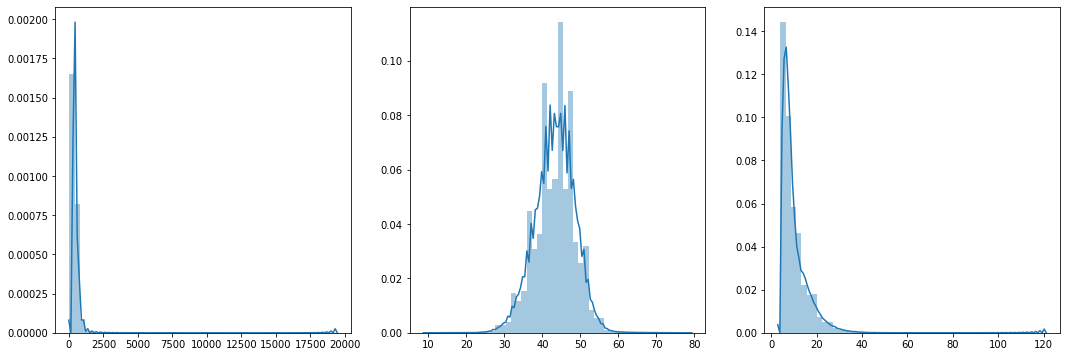

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
sns.distplot(article_lengths, ax=ax[0])
sns.distplot(article_length_trimmed, ax=ax[1])
sns.distplot(headline_lengths, ax=ax[2])
fig.show()

In [0]:
print(f'median article length is: {int(article_lengths.median())} words')
print(f'median article length (trimmed) is: {int(article_length_trimmed.median())} words')
print(f'median headline length is: {int(headline_lengths.median())} words')

median article length is: 358 words
median article length (trimmed) is: 44 words
median headline length is: 8 words


In [0]:
count_article = 0
count_article_trimmed = 0
count_headline = 0

for i in EPU_cleaned['Article']:
    if(len(i.split()) <= 550):
        count_article += 1

for i in EPU_raw['Article']:
    if(len(i.split()) <= 50):
        count_article_trimmed += 1

for i in EPU_cleaned['Headline']:
    if(len(i.split()) <= 20):
        count_headline += 1

print(f'Proportion of Articles under 550 words in length: {round(count_article / len(EPU_cleaned), 2)}')
print(f'Proportion of Articles (trimmed) under 50 words in length: {round(count_article_trimmed / len(EPU_raw), 2)}')
print(f'Proportion of Headline under 20 words in length: {round(count_headline / len(EPU_cleaned), 2)}')

Proportion of Articles under 550 words in length: 0.83
Proportion of Articles (trimmed) under 50 words in length: 0.93
Proportion of Headline under 20 words in length: 0.94


In [0]:
max_length_article = 550
max_length_article_trimmed = 50
max_length_headline = 20

#### Trim EPU Data Frame to Rows w/ Headline of 20 Words or Less

In [0]:
EPU_cleaned['headline_length'] = EPU_cleaned.apply(lambda row: len(row['Headline'].split()), axis=1)
EPU_raw['headline_length'] = EPU_raw.apply(lambda row: len(row['Headline'].split()), axis=1)

EPU_trimmed = EPU_cleaned.loc[EPU_cleaned['headline_length'] <= max_length_headline]
EPU_trimmed_trimmed = EPU_raw.loc[EPU_raw['headline_length'] <= max_length_headline]

### Add `START` & `END` Tokens to Headlines

In [0]:
EPU_trimmed['Headline'] = EPU_trimmed['Headline'].apply(lambda headline : 'tokenstart ' + headline + ' tokenend')
EPU_trimmed_trimmed['Headline'] = EPU_trimmed_trimmed['Headline'].apply(lambda headline : 'tokenstart ' + headline + ' tokenend')

### Checkpoint Data Save

In [0]:
EPU_trimmed.to_csv('EPU_checkpoint_full_new.csv')
EPU_trimmed_trimmed.to_csv('EPU_checkpoint_trimmed_new.csv')

# Language Model

## Test / Train Split

### Load Checkpoint Data

In [0]:
os.chdir('/gdrive/My Drive/colab_notebooks/information_systems/data')

##### Full Article Lengths

In [0]:
EPU_checkpoint = pd.read_csv('EPU_checkpoint_full_new.csv')

### Slice Down to `Article` & `Headline` Columns

In [0]:
EPU_seq = EPU_checkpoint[['Article', 'Headline', 'Label']]

#### Split Test / Train

In [0]:
EPU_train, EPU_test = train_test_split(EPU_seq, test_size=.10)

In [0]:
print(EPU_train.shape)
print(EPU_test.shape)

(250388, 3)
(27821, 3)


## Tokeniser

In [0]:
max_length_article = 550
max_length_headline = 20

### Run Tokenisers

In [0]:
article_tokeniser = Tokenizer()

In [0]:
article_tokeniser.fit_on_texts(list(EPU_train['Article']))
train_sequences_article = article_tokeniser.texts_to_sequences(EPU_train['Article'])
test_sequences_article = article_tokeniser.texts_to_sequences(EPU_test['Article'])

train_sequences_article = pad_sequences(train_sequences_article, maxlen=max_length_article, padding='post')
test_sequences_article = pad_sequences(test_sequences_article, maxlen=max_length_article, padding='post')

article_vocabulary = article_tokeniser.word_index
article_vocabulary_size = len(article_tokeniser.word_index) + 1
print(f'article vocabulary size: {article_vocabulary_size}')

article vocabulary size: 50739


In [0]:
headline_tokeniser = Tokenizer()

In [0]:
headline_tokeniser.fit_on_texts(list(EPU_train['Headline']))
train_sequences_headline = headline_tokeniser.texts_to_sequences(EPU_train['Headline'])
test_sequences_headline = headline_tokeniser.texts_to_sequences(EPU_test['Headline'])

train_sequences_headline = pad_sequences(train_sequences_headline, maxlen=max_length_headline, padding='post')
test_sequences_headline = pad_sequences(test_sequences_headline, maxlen=max_length_headline, padding='post')

headline_vocabulary = headline_tokeniser.word_index
headline_vocabulary_size = len(headline_tokeniser.word_index) + 1
print(f'headline vocabulary size: {headline_vocabulary_size}')

headline vocabulary size: 22487


### Pickle `Tokeniser` Objects

In [0]:
os.chdir('/gdrive/My Drive/colab_notebooks/information_systems/data/pickled_tokenisers')

### Article_trimmed

with open('tokenizer_article.pkl', 'wb') as article_tokeniser_out:
    pickle.dump(article_tokeniser, article_tokeniser_out, protocol=pickle.HIGHEST_PROTOCOL)

with open('train_sequences_article.pkl', 'wb') as train_sequences_article_out:
    pickle.dump(train_sequences_article, train_sequences_article_out, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('test_sequences_article.pkl', 'wb') as test_sequences_article_out:
    pickle.dump(test_sequences_article, test_sequences_article_out, protocol=pickle.HIGHEST_PROTOCOL)

### Headline

with open('tokenizer_headline.pkl', 'wb') as headline_tokeniser_out:
    pickle.dump(headline_tokeniser, headline_tokeniser_out, protocol=pickle.HIGHEST_PROTOCOL)

with open('train_sequences_headline.pkl', 'wb') as train_sequences_headline_out:
    pickle.dump(train_sequences_headline, train_sequences_headline_out, protocol=pickle.HIGHEST_PROTOCOL)

with open('test_sequences_headline.pkl', 'wb') as test_sequences_headline_out:
    pickle.dump(test_sequences_headline, test_sequences_headline_out, protocol=pickle.HIGHEST_PROTOCOL)

### Load `Tokeniser` Pickle Objects

In [0]:
os.chdir('/gdrive/My Drive/colab_notebooks/information_systems/data/pickled_tokenisers')

with open('tokenizer_article.pkl', 'rb') as article_tokeniser_in:
    article_tokeniser = pickle.load(article_tokeniser_in)
    article_vocabulary = article_tokeniser.word_index
    article_vocabulary_size = len(article_tokeniser.word_index) + 1

with open('train_sequences_article.pkl', 'rb') as train_sequences_article_in:
    train_sequences_article = pickle.load(train_sequences_article_in)

with open('test_sequences_article.pkl', 'rb') as test_sequences_article_in:
    test_sequences_article = pickle.load(test_sequences_article_in)

### Headline

with open('tokenizer_headline.pkl', 'rb') as headline_tokeniser_in:
    headline_tokeniser = pickle.load(headline_tokeniser_in)
    headline_vocabulary = headline_tokeniser.word_index
    headline_vocabulary_size = len(headline_tokeniser.word_index) + 1

with open('train_sequences_headline.pkl', 'rb') as train_sequences_headline_in:
    train_sequences_headline = pickle.load(train_sequences_headline_in)

with open('test_sequences_headline.pkl', 'rb') as test_sequences_headline_in:
    test_sequences_headline = pickle.load(test_sequences_headline_in)

os.chdir('/gdrive/My Drive/colab_notebooks/information_systems/data')

## Pre-Trained Embeddings

### GLoVe Embeddings

In [0]:
embeddings_index = {}
with open('GLoVe_embeddings/glove.6B.300d.txt') as glove_in:
    for line in glove_in:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

#### Prepare Embedding Matrix – Article

In [0]:
count_words = article_vocabulary_size
embedding_matrix = np.zeros((count_words, 300))
for word, i in combined_vocabulary.items():
    if i >= article_vocabulary_size:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_layer_combined = Embedding(count_words, 300, embeddings_initializer=Constant(embedding_matrix),
                                     input_length=max_length_article, trainable=False)

#### Prepare Embedding Matrix – Headline

In [0]:
count_words = headline_vocabulary_size
embedding_matrix = np.zeros((count_words, 300))
for word, i in headline_vocabulary_size.items():
    if i >= max_:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_layer_combined = Embedding(count_words, 300, embeddings_initializer=Constant(embedding_matrix),
                                     input_length=max_length_headline, trainable=False)

### GPT-2 Embeddings

#### Define Values for Embedding Logic / Layer

In [0]:
embedding_dimension = 768

#### Read GPT-2 Model / Tokeniser

In [0]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokeniser = GPT2Tokenizer.from_pretrained('gpt2')

In [0]:
word_embeddings = model.transformer.wte.weight
position_embeddings = model.transformer.wpe.weight

#### Prepare Embedding Matrix – Article

In [0]:
count_words = article_vocabulary_size
embedding_matrix = np.zeros((count_words, embedding_dimension))
for word, i in article_vocabulary.items():
    if i >= article_vocabulary_size:
        continue

    text_index = tokeniser.encode(word, add_prefix_space=True)
    embedding_vector_tensor = model.transformer.wte.weight[text_index, :]
    embedding_vector_np = embedding_vector_tensor.detach().numpy()[0]
    if embedding_vector_np is not None:
        embedding_matrix[i] = embedding_vector_np

In [0]:
embedding_layer_article = Embedding(count_words, embedding_dimension,
                                    embeddings_initializer=Constant(embedding_matrix),
                                    input_length=max_length_article,
                                    trainable=False)

#### Prepare Embedding Matrix – Headline

In [0]:
count_words = headline_vocabulary_size
embedding_matrix = np.zeros((count_words, embedding_dimension))
for word, i in headline_vocabulary.items():
    if i >= headline_vocabulary_size:
        continue

    text_index = tokeniser.encode(word, add_prefix_space=True)
    embedding_vector_tensor = model.transformer.wte.weight[text_index, :]
    embedding_vector_np = embedding_vector_tensor.detach().numpy()[0]
    if embedding_vector_np is not None:
        embedding_matrix[i] = embedding_vector_np

In [0]:
embedding_layer_headline = Embedding(count_words, embedding_dimension,
                                     embeddings_initializer=Constant(embedding_matrix),
                                     input_length=max_length_headline,
                                     trainable=False)

## Network

### Define Network (Full Articles)

In [0]:
### Constructor for baseline enc. dec. network.

latent_dimension = 256
encoder_input = Input(shape=(max_length_article, ))
decoder_input = Input(shape=(None, ))

# Encoder
encoder_embedding = embedding_layer_article(encoder_input) 

# GRU 1
encoder_gru_01 = Bidirectional(CuDNNGRU(latent_dimension, return_sequences=True, return_state=True))
encoder_output_01, encoder_forward_state_01, encoder_backward_state_01 = encoder_gru_01(encoder_embedding)
encoder_output_dropout_01 = Dropout(0.3)(encoder_output_01)

# GRU 2
encoder_gru_02 = Bidirectional(CuDNNGRU(latent_dimension, return_sequences=True, return_state=True))
encoder_output, encoder_forward_state, encoder_backward_state = encoder_gru_02(encoder_output_dropout_01)
encoder_state = Concatenate()([encoder_forward_state, encoder_backward_state])

# Decoder.
decoder_embedding = embedding_layer_headline(decoder_input)

# GRU using encoder_states as initial state
decoder_gru = CuDNNGRU(latent_dimension*2, return_sequences=True, return_state=True)
decoder_output, decoder_state = decoder_gru(decoder_embedding, initial_state=[encoder_state])

# Attention Layer
attention_layer = AttentionLayer() 
attention_out, attention_states = attention_layer([encoder_output, decoder_output])
  
# Concat attention output and decoder GRU output 
decoder_concatenate = Concatenate(axis=-1)([decoder_output, attention_out])

# Dense layer
decoder_dense = TimeDistributed(Dense(headline_vocabulary_size, activation='softmax')) #hierarchical
decoder_dense_output = decoder_dense(decoder_concatenate)

# Define the model
model = Model([encoder_input, decoder_input], decoder_dense_output)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

print(model.summary())

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 550)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 550, 768)     38941440    input_15[0][0]                   
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) [(None, 550, 512), ( 1575936     embedding[3][0]                  
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 550, 512)     0           bidirectional_6[0][0]            
___________________________________________________________________________________________

### Compile & Train Network

In [0]:
os.chdir('/gdrive/My Drive/colab_notebooks/information_systems/data/model_checkpoints')
callbacks = [ModelCheckpoint(filepath='encoder_decoder_01_{epoch:02d}-{val_loss:.2f}.hdf5'), 
             EarlyStopping(monitor='val_loss', patience=1, verbose=1, min_delta=1e-4, restore_best_weights=True)]

model_history = model.fit([train_sequences_article, train_sequences_headline[:, :-1]], 
                          train_sequences_headline.reshape(train_sequences_headline.shape[0], train_sequences_headline.shape[1], 1)[:, 1:], 
                          epochs=50, verbose=1, batch_size=150, callbacks=callbacks, validation_split=0.20, shuffle=True)

model.save('encoder_decoder_17.h5')

Train on 200310 samples, validate on 50078 samples
Epoch 1/50
200310/200310 [==============================] - 1561s 8ms/sample - loss: 3.1604 - val_loss: 2.9862
Epoch 2/50
200310/200310 [==============================] - 1563s 8ms/sample - loss: 2.8539 - val_loss: 2.8649
Epoch 3/50
200310/200310 [==============================] - 1558s 8ms/sample - loss: 2.7071 - val_loss: 2.7974
Epoch 4/50
200310/200310 [==============================] - 1572s 8ms/sample - loss: 2.5992 - val_loss: 2.7666
Epoch 5/50
200310/200310 [==============================] - 1564s 8ms/sample - loss: 2.5102 - val_loss: 2.7659
Epoch 6/50
200310/200310 [==============================] - 1565s 8ms/sample - loss: 2.4328 - val_loss: 2.7828
Epoch 00006: early stopping


### Construct Word Index to Word Dict.

In [0]:
reverse_target_word_index = headline_tokeniser.index_word
reverse_source_word_index = article_tokeniser.index_word
target_word_index = headline_tokeniser.word_index

### Define Inference Network

In [0]:
# Encoder Inference Model
encoder_model_inference = Model(encoder_input, [encoder_output, encoder_state])

# Decoder Inference
# Below tensors will hold the states of the previous time step
decoder_state = Input(shape=(latent_dimension*2, ))
decoder_intermittent_state_input = Input(shape=(max_length_article, latent_dimension*2))

# Get Embeddings of Decoder Sequence
decoder_embedding_inference = embedding_layer_headline(decoder_input)

# Predict Next Word in Sequence, Set Initial State to State from Previous Time Step
decoder_output_inference, decoder_state_inference = decoder_gru(decoder_embedding_inference, initial_state=[decoder_state])

# Attention Inference
attention_layer = AttentionLayer()
attention_out_inference, attention_state_inference = attention_layer([decoder_intermittent_state_input, decoder_output_inference])
decoder_inference_concat = Concatenate(axis=-1)([decoder_output_inference, attention_out_inference])

# Dense Softmax Layer to Generate Prob. Dist. Over Target Vocabulary
decoder_output_inference = decoder_dense(decoder_inference_concat)

# Final Decoder Model
decoder_model_inference = Model([decoder_input, decoder_intermittent_state_input, decoder_state], 
                                [decoder_output_inference, decoder_state_inference])

### Define Sequence Decoder Function

In [0]:
def decode_sequence(input_sequence):
  """Text generation function via encoder / decoder network."""

  # Encode Input as State Vectors.
  encoder_output, encoder_state = encoder_model_inference.predict(input_sequence)

  # Generate Empty Target Sequence of Length 1.
  target_sequence = np.zeros((1, 1))

  # Choose 'start' as the first word of the target sequence
  target_sequence[0, 0] = target_word_index['tokenstart']

  decoded_sentence = ''
  break_condition = False
  while not break_condition:
      token_output, decoder_state = decoder_model_inference.predict([target_sequence, encoder_output, encoder_state])

      # Sample Token
      sampled_token_index = np.argmax(token_output[0, -1, :])

      if not sampled_token_index == 0:
        sampled_token = reverse_target_word_index[sampled_token_index]

        if not sampled_token == 'tokenend':
            decoded_sentence += ' ' + sampled_token

        # Break Condition: Encounter Max Length / Find Stop Token.
        if sampled_token == 'tokenend' or len(decoded_sentence.split()) >= (max_length_headline - 1):
            break_condition = True

        # Update Target Sequence (length 1).
        target_sequence = np.zeros((1, 1))
        target_sequence[0, 0] = sampled_token_index

      else:
        print('BROKEN')
        break_condition = True

      # Update internal states
      encoder_state = decoder_state

  return decoded_sentence

#### Integer Sequence to Headline Text

In [0]:
def sequence_to_headline(input_sequence):
  new_string = ''
  for item in input_sequence:
    if (not item == 0 and not item == target_word_index['tokenstart']) and not item == target_word_index['tokenend']:
      new_string = new_string + reverse_target_word_index[item] + ' '

  return new_string

#### Integer Sequence to Article Text



In [0]:
def sequence_to_article(input_sequence):
  new_string = ''
  for item in input_sequence:
    if not item == 0:
      new_string = new_string + reverse_source_word_index[item] + ' '
  
  return new_string

#### Generate Test Summaries

In [0]:
for i in range(len(test_sequences_article))[:10]:
  print('Article:', sequence_to_article(test_sequences_article[i]))
  print('Original Headline:', sequence_to_headline(test_sequences_headline[i]))
  print('Predicted Headline:', decode_sequence(test_sequences_article[i].reshape(1, max_length_article)))
  print('\n')

Article: savvy consumer knows price gasoline drops service station convenience store competitors rush match beat price win customers goes products services days healthy competition drain flying public south east coast proposed billion hostile takeover delta air lines airways reality airline analysts beginning assert merger create monopoly conservatives believe healthy consumers new delta result airways delta air lines merger nations largest air carrier consider comments michael boyd president boyd group inc told wall street journal concentration flights destroy competition deep south stuart aviation consulting told reuters carriers overlap typically reduction service room upward pressure pricing loss competition critical monopolies good flying public federal government rejected bid airways merge united primarily overlapping flights airlines recently rejected merger northwest american airlines reason justice department duty sure merger harm public unfortunately consumers west recent mer

### Assign Generated Summaries to Data Frame & Save

In [0]:
EPU_train['Headline_Gen'] = [decode_sequence(sequence.reshape(1, max_length_article)) for sequence in train_sequences_article]
EPU_test['Headline_Gen'] = [decode_sequence(sequence.reshape(1, max_length_article)) for sequence in test_sequences_article]

In [0]:
EPU_train.to_csv('EPU complete_train_full.csv')
EPU_test.to_csv('EPU complete_train_full.csv')

## Fix Data Output

### Load Dataframe Checkpoint

In [0]:
EPU_train_full = pd.read_csv('EPU_complete_train_full.csv')
EPU_test_full = pd.read_csv('EPU_complete_test_full.csv')

In [0]:
test_df = pd.DataFrame()

In [0]:
sequences = [sequence_to_article(test_sequences_article[i]) for i in range(len(test_sequences_article))]
headlines = [sequence_to_headline(test_sequences_headline[i]) for i in range(len(test_sequences_headline))]

In [0]:
test_df['Article'] = sequences
test_df['Headline'] = headlines
test_df['Headline_Gen'] = EPU_test_full['Headline_Gen']

In [0]:
sequences = [sequence_to_article(train_sequences_article[i]) for i in range(len(train_sequences_article))]
headlines = [sequence_to_headline(train_sequences_headline[i]) for i in range(len(train_sequences_headline))]

In [0]:
train_df = pd.DataFrame()

In [0]:
train_df['Article'] = sequences
train_df['Headline'] = headlines
train_df['Headline_Gen'] = EPU_train_full['Headline_Gen']

In [0]:
EPU_test_full_clean = test_df
EPU_train_full_clean = train_df

In [0]:
EPU_test_full_clean.to_csv('EPU_complete_train_full_FIXED.csv')
EPU_train_full_clean.to_csv('EPU_complete_test_full_FIXED.csv')

### Load Fixed Checkpoint

In [0]:
EPU_train_full = pd.read_csv('EPU_complete_train_full_FIXED.csv')
EPU_test_full = pd.read_csv('EPU_complete_test_full_FIXED.csv')

In [0]:
labels_train = EPU_train[['Label']]
labels_test = EPU_test[['Label']]

In [0]:
EPU_train_full = pd.merge(EPU_train_full, labels_train, left_index=True, right_index=True)
EPU_test_full = pd.merge(EPU_test_full, labels_test, left_index=True, right_index=True)

## Scoring (Rouge / Bleu)

### Apply ROUGE Scoring Row-Wise

In [0]:
rouge = Rouge()
def rouge_scoring(row):

  reference = str(row['Headline'])
  candidate = str(row['Bench_Seed'])
  score = rouge.get_scores(candidate, reference)[0]['rouge-1']['r']

  return score

In [0]:
EPU_train_full['ROUGE'] = EPU_train_full.apply(lambda row: rouge_scoring(row), axis=1)
EPU_test_full['ROUGE'] = EPU_test_full.apply(lambda row: rouge_scoring(row), axis=1)

### Apply BLEU Scoring Row-Wise

In [0]:
def bleu_scoring(row):

  reference = row['Headline']
  candidate = row['Bench_Seed']

  reference = [str(reference).split()]
  candidate = str(candidate).split()
  score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))

  return score

In [0]:
EPU_train_full['BLEU'] = EPU_train_full.apply(lambda row: bleu_scoring(row), axis=1)
EPU_test_full['BLEU'] = EPU_test_full.apply(lambda row: bleu_scoring(row), axis=1)

In [0]:
def get_first_20(row):

  first_20 = ' '.join([word for i, word in enumerate(row['Article'].split()) if i <=20])
  return first_20

In [0]:
EPU_test_full['Bench_Seed'] = EPU_test_full.apply(lambda row: get_first_20(row), axis=1)

In [0]:
EPU_test_full['Baseline_ROUGE'] = EPU_test_full.apply(lambda row: rouge_scoring(row), axis=1)
EPU_test_full['Baseline_BLEU'] = EPU_test_full.apply(lambda row: bleu_scoring(row), axis=1)

In [0]:
EPU_test_full.to_csv('EPU_complete_train_full_FIXED_W_SCORES.csv')

# Classifier Networks for EPU

## Test / Train Split

### Load Checkpoint Data

In [0]:
os.chdir('/gdrive/My Drive/colab_notebooks/information_systems/data')

##### Original Data Frame

In [0]:
EPU_checkpoint = pd.read_csv('EPU_checkpoint_full_new.csv')

### Slice Down to `Article` & `Headline` Columns

In [0]:
EPU_cv_frame = EPU_checkpoint[['Newspaper', 'Date', 'Headline', 'Article', 'Label']]

In [0]:
EPU_seq = EPU_checkpoint[['Headline', 'Label']]

### Read `Train` & `Test` Frames w/ Prediticted Headlines

In [0]:
EPU_train_full = pd.read_csv('EPU_complete_train_full_FIXED.csv')
EPU_test_full = pd.read_csv('EPU_complete_test_full_FIXED.csv')

### Merge Tables on Article Text to Transfer Labels

In [0]:
EPU_seq['Headline'] = EPU_seq['Headline'].apply(lambda headline: headline.replace('tokenstart ', '').rstrip())
EPU_seq['Headline'] = EPU_seq['Headline'].apply(lambda headline: headline.replace('tokenend', '').rstrip())

In [0]:
EPU_train_full['Headline'] = EPU_train_full['Headline'].apply(lambda headline: headline.rstrip())
EPU_test_full['Headline'] = EPU_test_full['Headline'].apply(lambda headline: headline.rstrip())

In [0]:
EPU_test_full = EPU_test_full.merge(EPU_seq, on='Headline')[['Article', 'Headline', 'Headline_Gen', 'Label']]
EPU_train_full = EPU_train_full.merge(EPU_seq, on='Headline')[['Article', 'Headline', 'Headline_Gen', 'Label']]

### Remove Target Leak Risks

In [0]:
def clean_target_leak(article):
  
  leak_strings = ['uncertainty', 'uncertain', 'policy']
  leak_strings_sub = [' ' + word for word in leak_strings]
  leak_strings_sub.extend([word + ' ' for word in leak_strings])

  article_out = article
  for word in leak_strings_sub:
    article_out = article_out.replace(word, '')

  return article_out

In [0]:
EPU_cv_frame['Article'] = EPU_cv_frame['Article'].apply(lambda article: clean_target_leak(article))
EPU_cv_frame['Headline'] = EPU_cv_frame['Headline'].apply(lambda headline: clean_target_leak(headline))

In [0]:
EPU_train_full['Article'] = EPU_train_full['Article'].apply(lambda article: clean_target_leak(article))
EPU_train_full['Headline'] = EPU_train_full['Headline'].apply(lambda headline: clean_target_leak(headline))

### Combine `Headline` & `Article` Fields

In [0]:
EPU_cv_frame['combined_org'] = EPU_cv_frame.apply(lambda row: row['Headline'] + ' ' + row['Article'], axis=1)

In [0]:
EPU_train_full['combined_org'] = EPU_train_full.apply(lambda row: row['Headline'] + ' ' + row['Article'], axis=1)
EPU_test_full['combined_org'] = EPU_test_full.apply(lambda row: row['Headline'] + ' ' + row['Article'], axis=1)

In [0]:
EPU_train_full['combined_gen'] = EPU_train_full.apply(lambda row: str(row['Headline_Gen']) + ' ' + row['Article'], axis=1)
EPU_test_full['combined_gen'] = EPU_test_full.apply(lambda row: str(row['Headline_Gen']) + ' ' + row['Article'], axis=1)

## Tokeniser

In [0]:
max_length_article = 550
max_length_combined = 570

### Run Tokenisers

In [0]:
cv_tokeniser = Tokenizer()

In [0]:
cv_tokeniser.fit_on_texts(list(EPU_cv_frame['combined_org']))
cv_sequences = cv_tokeniser.texts_to_sequences(EPU_cv_frame['combined_org'])
cv_sequences = pad_sequences(cv_sequences, maxlen=max_length_combined, padding='post')

cv_vocabulary = cv_tokeniser.word_index
cv_vocabulary_size = len(cv_tokeniser.word_index) + 1
print(f'article vocabulary size: {cv_vocabulary_size}')

article vocabulary size: 55282


In [0]:
article_tokeniser = Tokenizer()

In [0]:
article_tokeniser.fit_on_texts(list(EPU_train_full['Article']))
train_sequences_article = article_tokeniser.texts_to_sequences(EPU_train_full['Article'])
test_sequences_article = article_tokeniser.texts_to_sequences(EPU_test_full['Article'])

train_sequences_article = pad_sequences(train_sequences_article, maxlen=max_length_article, padding='post')
test_sequences_article = pad_sequences(test_sequences_article, maxlen=max_length_article, padding='post')

article_vocabulary = article_tokeniser.word_index
article_vocabulary_size = len(article_tokeniser.word_index) + 1
print(f'article vocabulary size: {article_vocabulary_size}')

article vocabulary size: 53759


In [0]:
combined_tokeniser_original = Tokenizer()

In [0]:
combined_tokeniser_original.fit_on_texts(list(EPU_train_full['combined_org']))
train_sequences_combined_org = combined_tokeniser_original.texts_to_sequences(EPU_train_full['combined_org'])
test_sequences_combined_org = combined_tokeniser_original.texts_to_sequences(EPU_test_full['combined_org'])

train_sequences_combined_org = pad_sequences(train_sequences_combined_org, maxlen=max_length_combined, padding='post')
test_sequences_combined_org = pad_sequences(test_sequences_combined_org, maxlen=max_length_combined, padding='post')

combined_vocabulary_org = combined_tokeniser_original.word_index
combined_vocabulary_org_size = len(combined_tokeniser_original.word_index) + 1
print(f'combined vocabulary size: {combined_vocabulary_org_size}')

combined vocabulary size: 54632


In [0]:
combined_tokeniser_generated = Tokenizer()

In [0]:
combined_tokeniser_generated.fit_on_texts(list(EPU_train_full['combined_gen']))
train_sequences_combined_gen = combined_tokeniser_generated.texts_to_sequences(EPU_train_full['combined_gen'])
test_sequences_combined_gen = combined_tokeniser_generated.texts_to_sequences(EPU_test_full['combined_gen'])

train_sequences_combined_gen = pad_sequences(train_sequences_combined_gen, maxlen=max_length_combined, padding='post')
test_sequences_combined_gen = pad_sequences(test_sequences_combined_gen, maxlen=max_length_combined, padding='post')

combined_vocabulary_gen = combined_tokeniser_generated.word_index
combined_vocabulary_gen_size = len(combined_tokeniser_generated.word_index) + 1
print(f'combined vocabulary size: {combined_vocabulary_gen_size}')

combined vocabulary size: 53965


### Pickle `Tokeniser` Objects

In [0]:
os.chdir('/gdrive/My Drive/colab_notebooks/information_systems/data/pickled_tokenisers/classifier')

### CV

with open('tokenizer_cv.pkl', 'wb') as cv_tokeniser_out:
    pickle.dump(cv_tokeniser, cv_tokeniser_out, protocol=pickle.HIGHEST_PROTOCOL)

with open('cv_sequences.pkl', 'wb') as cv_sequences_out:
    pickle.dump(cv_sequences, cv_sequences_out, protocol=pickle.HIGHEST_PROTOCOL)

### Article

with open('tokenizer_article.pkl', 'wb') as article_tokeniser_out:
    pickle.dump(article_tokeniser, article_tokeniser_out, protocol=pickle.HIGHEST_PROTOCOL)

with open('train_sequences_article.pkl', 'wb') as train_sequences_article_out:
    pickle.dump(train_sequences_article, train_sequences_article_out, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('test_sequences_article.pkl', 'wb') as test_sequences_article_out:
    pickle.dump(test_sequences_article, test_sequences_article_out, protocol=pickle.HIGHEST_PROTOCOL)

### Combined Original

with open('tokenizer_combined_org.pkl', 'wb') as combined_tokeniser_org_out:
    pickle.dump(combined_tokeniser_original, combined_tokeniser_org_out, protocol=pickle.HIGHEST_PROTOCOL)

with open('train_sequences_combined_org.pkl', 'wb') as train_sequences_combined_org_out:
    pickle.dump(train_sequences_combined_org, train_sequences_combined_org_out, protocol=pickle.HIGHEST_PROTOCOL)

with open('test_sequences_combined_org.pkl', 'wb') as test_sequences_combined_org_out:
    pickle.dump(test_sequences_combined_org, test_sequences_combined_org_out, protocol=pickle.HIGHEST_PROTOCOL)

### Combined Generated

with open('tokenizer_combined_gen.pkl', 'wb') as combined_tokeniser_gen_out:
    pickle.dump(combined_tokeniser_generated, combined_tokeniser_gen_out, protocol=pickle.HIGHEST_PROTOCOL)

with open('train_sequences_combined_gen.pkl', 'wb') as train_sequences_combined_gen_out:
    pickle.dump(train_sequences_combined_gen, train_sequences_combined_gen_out, protocol=pickle.HIGHEST_PROTOCOL)

with open('test_sequences_combined_gen.pkl', 'wb') as test_sequences_combined_gen_out:
    pickle.dump(test_sequences_combined_gen, test_sequences_combined_gen_out, protocol=pickle.HIGHEST_PROTOCOL)

### Load `Tokeniser` Pickle Objects

In [0]:
os.chdir('/gdrive/My Drive/colab_notebooks/information_systems/data/pickled_tokenisers/classifier')

### CV

with open('tokenizer_cv.pkl', 'rb') as cv_tokeniser_in:
    cv_tokeniser = pickle.load(cv_tokeniser_in)
    cv_vocabulary = cv_tokeniser.word_index
    cv_vocabulary_size = len(cv_tokeniser.word_index) + 1

with open('cv_sequences.pkl', 'rb') as cv_sequences_in:
    cv_sequences = pickle.load(cv_sequences_in)

### Article

with open('tokenizer_article.pkl', 'rb') as article_tokeniser_in:
    article_tokeniser = pickle.load(article_tokeniser_in)
    article_vocabulary = article_tokeniser.word_index
    article_vocabulary_size = len(article_tokeniser.word_index) + 1

with open('train_sequences_article.pkl', 'rb') as train_sequences_article_in:
    train_sequences_article = pickle.load(train_sequences_article_in)

with open('test_sequences_article.pkl', 'rb') as test_sequences_article_in:
    test_sequences_article = pickle.load(test_sequences_article_in)

### Combined Original

with open('tokenizer_combined_org.pkl', 'rb') as combined_org_tokeniser_in:
    combined_tokeniser_original = pickle.load(combined_org_tokeniser_in)
    combined_vocabulary_org = combined_tokeniser_original.word_index
    combined_vocabulary_org_size = len(combined_tokeniser_original.word_index) + 1

with open('train_sequences_combined_org.pkl', 'rb') as train_sequences_combined_org_in:
    train_sequences_combined_org = pickle.load(train_sequences_combined_org_in)

with open('test_sequences_combined_org.pkl', 'rb') as test_sequences_combined_org_in:
    test_sequences_combined_org = pickle.load(test_sequences_combined_org_in)

### Combined Generated

with open('tokenizer_combined_gen.pkl', 'rb') as combined_gen_tokeniser_in:
    combined_tokeniser_generated = pickle.load(combined_gen_tokeniser_in)
    combined_vocabulary_gen = combined_tokeniser_generated.word_index
    combined_vocabulary_gen_size = len(combined_tokeniser_generated.word_index) + 1

with open('train_sequences_combined_gen.pkl', 'rb') as train_sequences_combined_gen_in:
    train_sequences_combined_gen = pickle.load(train_sequences_combined_gen_in)

with open('test_sequences_combined_gen.pkl', 'rb') as test_sequences_combined_gen_in:
    test_sequences_combined_gen = pickle.load(test_sequences_combined_gen_in)

os.chdir('/gdrive/My Drive/colab_notebooks/information_systems/data')

## Pre-Trained Embeddings

#### Define Values for Embedding Logic / Layer

In [0]:
embedding_dimension = 768

#### Read GPT-2 Model / Tokeniser

In [0]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokeniser = GPT2Tokenizer.from_pretrained('gpt2')

In [0]:
word_embeddings = model.transformer.wte.weight
position_embeddings = model.transformer.wpe.weight

#### Prepare Embedding Matrix – CV

In [0]:
count_words = cv_vocabulary_size
embedding_matrix = np.zeros((count_words, embedding_dimension))
for word, i in cv_vocabulary.items():
    if i >= cv_vocabulary_size:
        continue

    text_index = tokeniser.encode(word, add_prefix_space=True)
    embedding_vector_tensor = model.transformer.wte.weight[text_index, :]
    embedding_vector_np = embedding_vector_tensor.detach().numpy()[0]
    if embedding_vector_np is not None:
        embedding_matrix[i] = embedding_vector_np

In [0]:
embedding_layer_cv = Embedding(count_words, embedding_dimension,
                               embeddings_initializer=Constant(embedding_matrix),
                               input_length=max_length_combined,
                               trainable=False)

#### Prepare Embedding Matrix – Article

In [0]:
count_words = article_vocabulary_size
embedding_matrix = np.zeros((count_words, embedding_dimension))
for word, i in article_vocabulary.items():
    if i >= article_vocabulary_size:
        continue

    text_index = tokeniser.encode(word, add_prefix_space=True)
    embedding_vector_tensor = model.transformer.wte.weight[text_index, :]
    embedding_vector_np = embedding_vector_tensor.detach().numpy()[0]
    if embedding_vector_np is not None:
        embedding_matrix[i] = embedding_vector_np

In [0]:
embedding_layer_article = Embedding(count_words, embedding_dimension,
                                    embeddings_initializer=Constant(embedding_matrix),
                                    input_length=max_length_article,
                                    trainable=False)

#### Prepare Embedding Matrix – Combined Original

In [0]:
count_words = combined_vocabulary_org_size
embedding_matrix = np.zeros((count_words, embedding_dimension))
for word, i in combined_vocabulary_org.items():
    if i >= combined_vocabulary_org_size:
        continue

    text_index = tokeniser.encode(word, add_prefix_space=True)
    embedding_vector_tensor = model.transformer.wte.weight[text_index, :]
    embedding_vector_np = embedding_vector_tensor.detach().numpy()[0]
    if embedding_vector_np is not None:
        embedding_matrix[i] = embedding_vector_np

In [0]:
embedding_layer_combined_org = Embedding(count_words, embedding_dimension,
                                         embeddings_initializer=Constant(embedding_matrix),
                                         input_length=max_length_combined,
                                         trainable=False)

#### Prepare Embedding Matrix – Combined Generated

In [0]:
count_words = combined_vocabulary_gen_size
embedding_matrix = np.zeros((count_words, embedding_dimension))
for word, i in combined_vocabulary_gen.items():
    if i >= combined_vocabulary_gen_size:
        continue

    text_index = tokeniser.encode(word, add_prefix_space=True)
    embedding_vector_tensor = model.transformer.wte.weight[text_index, :]
    embedding_vector_np = embedding_vector_tensor.detach().numpy()[0]
    if embedding_vector_np is not None:
        embedding_matrix[i] = embedding_vector_np

In [0]:
embedding_layer_combined_gen = Embedding(count_words, embedding_dimension,
                                         embeddings_initializer=Constant(embedding_matrix),
                                         input_length=max_length_combined,
                                         trainable=False)

## Classifier w/ Original Headlines

In [0]:
def build_GRU_Keras_original():
  """Constructor for GRU network with original headlines combined with articles."""
  
  model_gpt = Sequential() 
  model_gpt.add(embedding_layer_combined_org)
  model_gpt.add(Bidirectional(CuDNNGRU(180, return_sequences=True)))

  model_gpt.add(Dropout(0.3))
  model_gpt.add(Attention(max_length_combined))

  model_gpt.add(Dense(1, activation="sigmoid"))
  model_gpt.compile(loss="binary_crossentropy", optimizer='rmsprop', metrics=["accuracy"])
  model_gpt.summary()

  return model_gpt

### Fit Model w/ Original Headlines

In [0]:
os.chdir('/gdrive/My Drive/colab_notebooks/information_systems/data/model_checkpoints')
callbacks = [ModelCheckpoint(filepath='seq2seq_classifier_original_{epoch:02d}-{val_loss:.2f}.hdf5'), 
             EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4, restore_best_weights=True)]

model_GRU_Keras = build_GRU_Keras_original()
model_GRU_Keras.fit(train_sequences_combined_org, EPU_train_full['Label'].values, epochs=15, 
                    verbose=1, batch_size=56, validation_split=0.3, shuffle=True, callbacks=callbacks)

model_GRU_Keras.save('seq2seq_classifier_original_04.h5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 570, 768)          41957376  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 570, 360)          1026000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 570, 360)          0         
_________________________________________________________________
attention_2 (Attention)      (None, 360)               930       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 361       
Total params: 42,984,667
Trainable params: 1,027,291
Non-trainable params: 41,957,376
_________________________________________________________________
Train on 177652 samples, validate on 76137 samples
Epoch 1/15
177652/177652 [=======================

#### Calculate ROC Curve and AUC Score

In [0]:
fpr, tpr, thresholds = metrics.roc_curve(EPU_test_full['Label'].values, model_GRU_Keras.predict(test_sequences_combined_org))
metrics.auc(fpr, tpr)

0.9546264849790569

## Classifier w/ Generated Headlines

In [0]:
def build_GRU_Keras_generated():
  """Constructor for GRU network with original headlines combined with articles."""
  
  model_gpt = Sequential() 
  model_gpt.add(embedding_layer_combined_gen)
  model_gpt.add(Bidirectional(CuDNNGRU(180, return_sequences=True)))

  model_gpt.add(Dropout(0.3))
  model_gpt.add(Attention(max_length_combined))

  model_gpt.add(Dense(1, activation="sigmoid"))
  model_gpt.compile(loss="binary_crossentropy", optimizer='rmsprop', metrics=["accuracy"])
  model_gpt.summary()

  return model_gpt

### Fit Model w/ Generated Headlines

In [0]:
os.chdir('/gdrive/My Drive/colab_notebooks/information_systems/data/model_checkpoints')
callbacks = [ModelCheckpoint(filepath='seq2seq_classifier_generated_{epoch:02d}-{val_loss:.2f}.hdf5'), 
             EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4, restore_best_weights=True)]

model_GRU_Keras = build_GRU_Keras_generated()
model_GRU_Keras.fit(train_sequences_combined_gen, EPU_train_full['Label'].values, epochs=15, 
                    verbose=1, batch_size=56, validation_split=0.3, shuffle=True, callbacks=callbacks)

model_GRU_Keras.save('seq2seq_classifier_generated_01.h5')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 570, 768)          41445120  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 570, 360)          1026000   
_________________________________________________________________
dropout_4 (Dropout)          (None, 570, 360)          0         
_________________________________________________________________
attention_3 (Attention)      (None, 360)               930       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 361       
Total params: 42,472,411
Trainable params: 1,027,291
Non-trainable params: 41,445,120
_________________________________________________________________
Train on 177652 samples, validate on 76137 samples
Epoch 1/15
177652/177652 [=======================

#### Calculate ROC Curve and AUC Score

In [0]:
fpr, tpr, thresholds = metrics.roc_curve(EPU_test_full['Label'].values, model_GRU_Keras.predict(test_sequences_combined_gen))
metrics.auc(fpr, tpr)

0.955308939361928

### Remove Target Leak & Re-Tokenise / Embed

In [0]:
EPU_train_full['combined_gen'] = EPU_train_full['combined_gen'].apply(lambda combined_text: clean_target_leak(combined_text))

#### Tokenise

In [0]:
combined_tokeniser_generated = Tokenizer()

In [0]:
combined_tokeniser_generated.fit_on_texts(list(EPU_train_full['combined_gen']))
train_sequences_combined_gen = combined_tokeniser_generated.texts_to_sequences(EPU_train_full['combined_gen'])
test_sequences_combined_gen = combined_tokeniser_generated.texts_to_sequences(EPU_test_full['combined_gen'])

train_sequences_combined_gen = pad_sequences(train_sequences_combined_gen, maxlen=max_length_combined, padding='post')
test_sequences_combined_gen = pad_sequences(test_sequences_combined_gen, maxlen=max_length_combined, padding='post')

combined_vocabulary_gen = combined_tokeniser_generated.word_index
combined_vocabulary_gen_size = len(combined_tokeniser_generated.word_index) + 1
print(f'combined vocabulary size: {combined_vocabulary_gen_size}')

combined vocabulary size: 53967


#### Prepare Embedding Matrix – Combined Generated

In [0]:
count_words = combined_vocabulary_gen_size
embedding_matrix = np.zeros((count_words, embedding_dimension))
for word, i in combined_vocabulary_gen.items():
    if i >= combined_vocabulary_gen_size:
        continue

    text_index = tokeniser.encode(word, add_prefix_space=True)
    embedding_vector_tensor = model.transformer.wte.weight[text_index, :]
    embedding_vector_np = embedding_vector_tensor.detach().numpy()[0]
    if embedding_vector_np is not None:
        embedding_matrix[i] = embedding_vector_np

In [0]:
embedding_layer_combined_gen = Embedding(count_words, embedding_dimension,
                                         embeddings_initializer=Constant(embedding_matrix),
                                         input_length=max_length_combined,
                                         trainable=False)

### Run Model Again

In [0]:
os.chdir('/gdrive/My Drive/colab_notebooks/information_systems/data/model_checkpoints')
callbacks = [ModelCheckpoint(filepath='seq2seq_classifier_generated_{epoch:02d}-{val_loss:.2f}.hdf5'), 
             EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4, restore_best_weights=True)]

model_GRU_Keras = build_GRU_Keras_generated()
model_GRU_Keras.fit(train_sequences_combined_gen, EPU_train_full['Label'].values, epochs=15, 
                    verbose=1, batch_size=56, validation_split=0.3, shuffle=True, callbacks=callbacks)

model_GRU_Keras.save('seq2seq_classifier_generated_02.h5')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 570, 768)          41446656  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 570, 360)          1026000   
_________________________________________________________________
dropout_5 (Dropout)          (None, 570, 360)          0         
_________________________________________________________________
attention_4 (Attention)      (None, 360)               930       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 361       
Total params: 42,473,947
Trainable params: 1,027,291
Non-trainable params: 41,446,656
_________________________________________________________________
Train on 177652 samples, validate on 76137 samples
Epoch 1/15
177652/177652 [=======================

#### Calculate ROC Curve and AUC Score

In [0]:
fpr, tpr, thresholds = metrics.roc_curve(EPU_test_full['Label'].values, model_GRU_Keras.predict(test_sequences_combined_gen))
metrics.auc(fpr, tpr)

0.9369845361442117

## Classifier w/o Headlines

In [0]:
def build_GRU_Keras_article():
  """Constructor for GRU network with original headlines combined with articles."""
  
  model_gpt = Sequential() 
  model_gpt.add(embedding_layer_article)
  model_gpt.add(Bidirectional(CuDNNGRU(180, return_sequences=True)))

  model_gpt.add(Dropout(0.3))
  model_gpt.add(Attention(max_length_article))

  model_gpt.add(Dense(1, activation="sigmoid"))
  model_gpt.compile(loss="binary_crossentropy", optimizer='rmsprop', metrics=["accuracy"])
  model_gpt.summary()

  return model_gpt

### Fit Model w/o Headlines

In [0]:
os.chdir('/gdrive/My Drive/colab_notebooks/information_systems/data/model_checkpoints')
callbacks = [ModelCheckpoint(filepath='seq2seq_classifier_article_{epoch:02d}-{val_loss:.2f}.hdf5'), 
             EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4, restore_best_weights=True)]

model_GRU_Keras = build_GRU_Keras_article()
model_GRU_Keras.fit(train_sequences_article, EPU_train_full['Label'].values, epochs=15, 
                    verbose=1, batch_size=56, validation_split=0.3, shuffle=True, callbacks=callbacks)

model_GRU_Keras.save('seq2seq_classifier_article_01.h5')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 550, 768)          41286912  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 550, 360)          1026000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 550, 360)          0         
_________________________________________________________________
attention_5 (Attention)      (None, 360)               910       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 361       
Total params: 42,314,183
Trainable params: 1,027,271
Non-trainable params: 41,286,912
_________________________________________________________________
Train on 177652 samples, validate on 76137 samples
Epoch 1/15
177652/177652 [=======================

#### Calculate ROC Curve and AUC Score

In [0]:
fpr, tpr, thresholds = metrics.roc_curve(EPU_test_full['Label'].values, model_GRU_Keras.predict(test_sequences_article))
metrics.auc(fpr, tpr)

0.9434164710808457

## Cross Validation for Winning Model

### Import Modules

In [0]:
from sklearn.model_selection import StratifiedKFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report

### Define Network Builder

In [0]:
def create_network():
  """Build network for CV."""

  model_gpt = Sequential() 
  model_gpt.add(embedding_layer_cv)
  model_gpt.add(Bidirectional(CuDNNGRU(180, return_sequences=True)))

  model_gpt.add(Dropout(0.3))
  model_gpt.add(Attention(max_length_combined))

  model_gpt.add(Dense(1, activation="sigmoid"))
  model_gpt.compile(loss="binary_crossentropy", optimizer='rmsprop', metrics=["accuracy"])
  model_gpt.summary()
  
  return model_gpt

In [0]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=1, min_delta=1e-4, restore_best_weights=True)]

classifier = KerasClassifier(
    build_fn=create_network, 
    batch_size=56, epochs=8, 
    validation_split=0.3, verbose=1, 
    shuffle=True,
    callbacks=callbacks
  )

### Define Data Vessels

In [0]:
auc_list = []
f1_list = []
stored_predictions = pd.DataFrame(columns=['Index', 'Prediction'])

### Fire Cross Validation Loop

In [0]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=54)
for train_index, test_index in cv.split(cv_sequences, EPU_cv_frame['Label'].values):

    # Slice original data via cv indices.
    X_train, X_test = np.asarray(cv_sequences)[train_index], np.asarray(cv_sequences)[test_index]
    y_train, y_test = EPU_cv_frame['Label'].values[train_index], EPU_cv_frame['Label'].values[test_index]

    # Fit classifier.
    classifier.fit(X_train, y_train)

    # Predict target using trained (fitted) model.
    prediction_out = classifier.predict_proba(X_test)
    target_prediction = prediction_out[:, 1]
    
    # Calculate & store AUC scores.
    fpr, tpr, thresholds = metrics.roc_curve(y_test, target_prediction)
    roc_auc = metrics.auc(fpr, tpr)
    auc_list.append(roc_auc)
    
    # Store predictions and real target values in results frame.
    results_frame = pd.DataFrame({
        'Index': test_index, 
        'Prediction': target_prediction, 
        'True': y_test
        })
    
    results_frame = results_frame.reset_index(drop=True)

    # Add iteration results to master output data frame. 
    stored_predictions = pd.concat([stored_predictions, results_frame], axis=0)
    
    # Calculate & store F1 scores.
    target_prediction_round = np.around(target_prediction, decimals=0)
    f1_list.append(classification_report(y_test, target_prediction_round, output_dict=True)['1']['f1-score'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 570, 768)          42456576  
_________________________________________________________________
bidirectional (Bidirectional (None, 570, 360)          1026000   
_________________________________________________________________
dropout (Dropout)            (None, 570, 360)          0         
_________________________________________________________________
attention (Attention)        (None, 360)               930       
_________________________________________________________________
dense (Dense)                (None, 1)                 361       
Total params: 43,483,867
Trainable params: 1,027,291
Non-trainable params: 42,456,576
_________________________________________________________________
Train on 155796 samples, validate on 66771 samples
Epoch 1/8
155796/155796 [==========================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 570, 768)          42456576  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 570, 360)          1026000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 570, 360)          0         
_________________________________________________________________
attention_1 (Attention)      (None, 360)               930       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 361       
Total params: 43,483,867
Trainable params: 1,027,291
Non-trainable params: 42,456,576
_________________________________________________________________
Train on 155796 samples, validate on 66771 samples
Epoch 1/8
155796/155796 [========================

In [0]:
os.chdir('/gdrive/My Drive/colab_notebooks/information_systems/data/model_checkpoints')
stored_predictions.to_csv('cross_validation_results_03.csv')

In [0]:
DNN_scores = pd.DataFrame({'AUC': auc_list,'F-score': f1_list})
DNN_scores

,AUC,F-score
0,0.942321,0.566832
1,0.947261,0.613975
2,0.943178,0.571776
3,0.936210,0.583514
4,0.936837,0.575829


### Match Predictions to Data

#### Merge Tables on Article Text to Transfer Labels

In [0]:
os.chdir('/gdrive/My Drive/colab_notebooks/information_systems/data/model_checkpoints')
stored_predictions = pd.read_csv('cross_validation_results_03.csv')

In [0]:
# EPU_final_reindexed = EPU_cv_frame.merge(stored_predictions, on='Headline')[['Index', 'Newspaper', 'Date']]

In [0]:
final_output = pd.merge(EPU_cv_frame, stored_predictions, left_index=True, right_on='Index')[['Index', 'Newspaper', 'Date', 'Prediction', 'True']]
final_output.to_csv('final_output_02.csv')

In [0]:
final_output

,Index,Newspaper,Date,Prediction,True,Label
222568,0,The Washington Post,2006-01-01,0.997151,1.0,1
166926,1,The Washington Post,2006-01-01,0.000004,0.0,0
166927,2,The Washington Post,2006-01-01,0.000021,0.0,0
111284,3,The Washington Post,2006-01-01,0.000031,0.0,0
111285,4,The Washington Post,2006-01-01,0.000012,0.0,0
...,...,...,...,...,...,...
278207,278204,The New York Post,2019-04-30,0.180472,0.0,0
222567,278205,The New York Post,2019-04-30,0.676777,0.0,0
55640,278206,Pittsburgh Post-Gazette (Pennsylvania),2019-04-30,0.138745,0.0,0
278208,278207,Tampa Bay Times,NaN,0.000024,0.0,0
